In [17]:
import pandas as pd
# Plots
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import numpy as np
import pandas as pd
from imblearn.over_sampling import RandomOverSampler, SMOTE
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, precision_score, recall_score, f1_score, \
    RocCurveDisplay, plot_roc_curve, PrecisionRecallDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Describe data,use get_dummies to create dummies for category features


In [18]:
df = pd.read_csv("Titanic/train.csv")
df_test = pd.read_csv('Titanic/test.csv')
feature = ['Survived', 'Pclass','Sex','Age', 'SibSp','Parch','Fare','Embarked']
df = df[feature]
DataDummies = pd.get_dummies(df)
DataDummies

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.0000,0,1,0,0,1
887,1,1,19.0,0,0,30.0000,1,0,0,0,1
888,0,3,NaN,1,2,23.4500,1,0,0,0,1
889,1,1,26.0,0,0,30.0000,0,1,1,0,0


# Generate Correlation Matrix

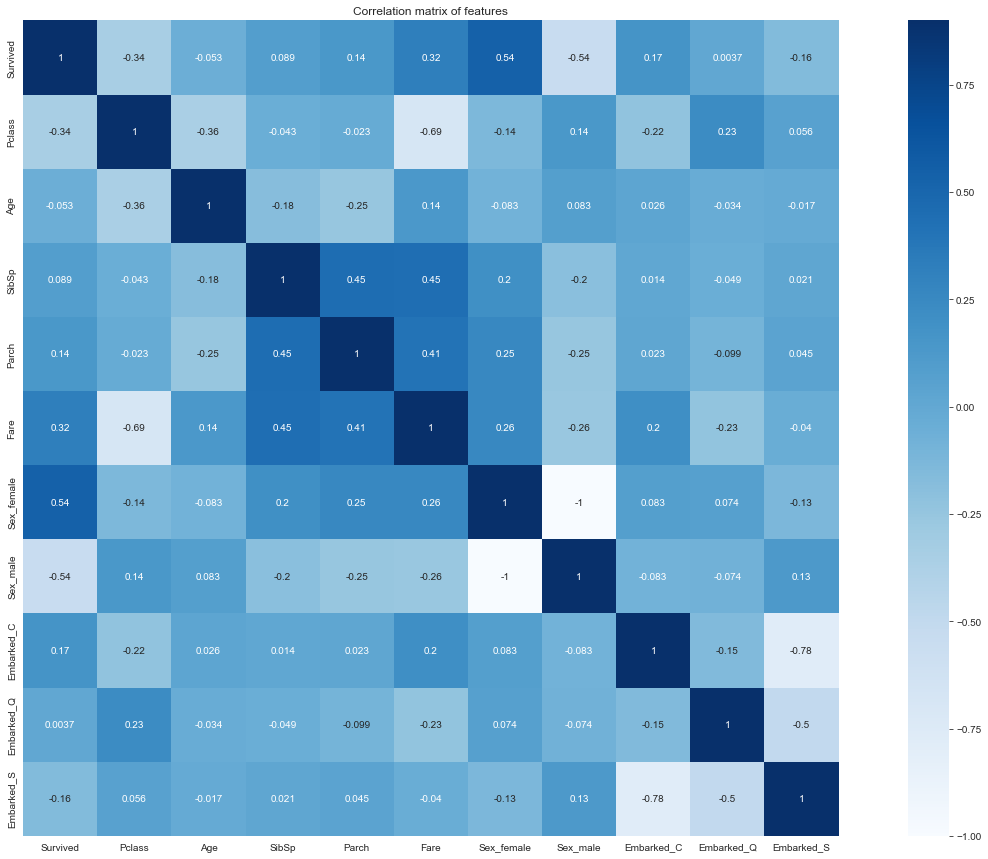

In [33]:
corr = DataDummies.corr(method='spearman')
fig, ax = plt.subplots(figsize=(25,15))
sns.heatmap(corr, vmax = 0.9, annot= True,cmap = "Blues",square = True)
plt.title("Correlation matrix of features")
plt.show()
plt.close()

   Pclass  Count
0       1    216
1       2    184
2       3    491


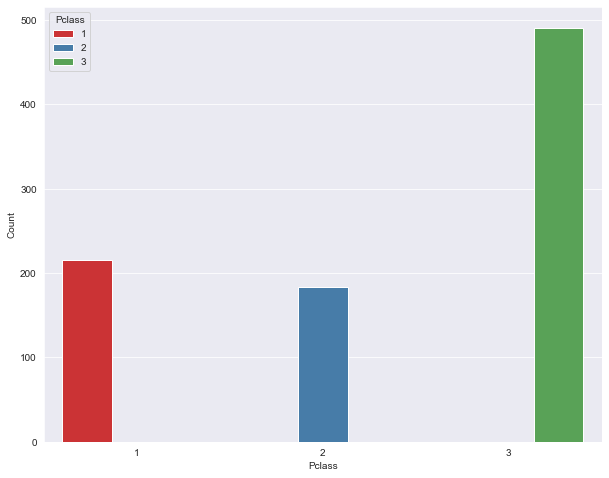

   If_women_or_children  Count
0                   0.0    540
1                   1.0    351


<Figure size 432x288 with 0 Axes>

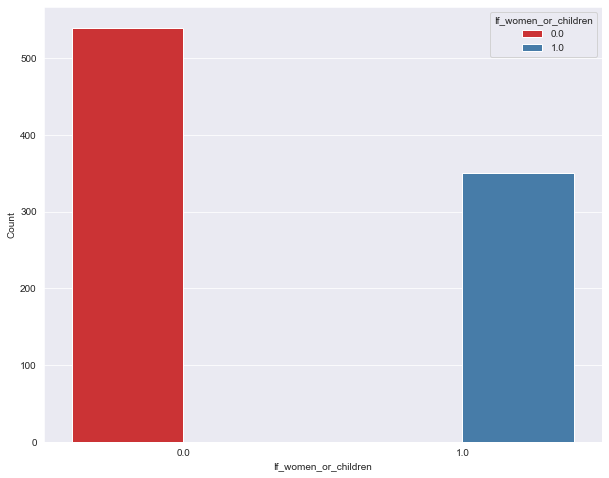

   Family_size  Count
0          0.0    537
1          1.0    161
2          2.0    102
3          3.0     29
4          4.0     15
5          5.0     22
6          6.0     12
7          7.0      6
8         10.0      7


<Figure size 432x288 with 0 Axes>

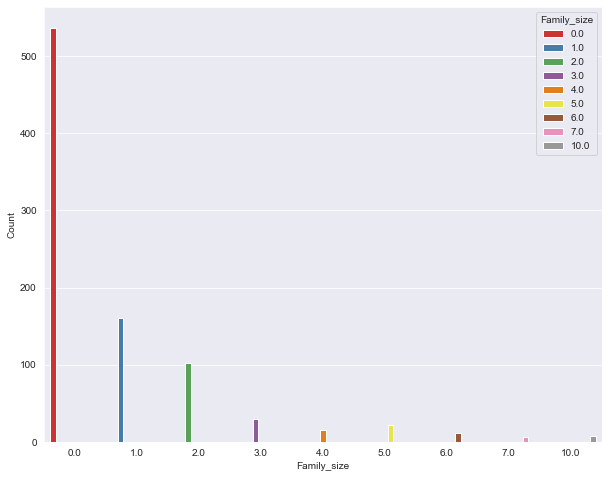

   If_not_from_Southampton  Count
0                      0.0    646
1                      1.0    245


<Figure size 432x288 with 0 Axes>

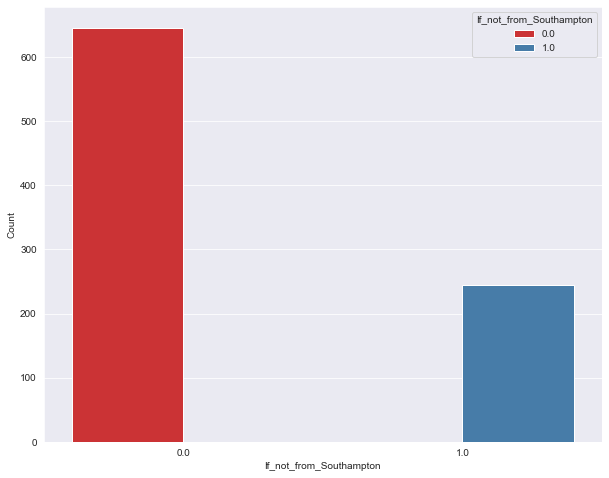

<Figure size 432x288 with 0 Axes>

In [37]:
titles = df.columns.values
for item in titles:
    bp = df.groupby([item]).size().reset_index(name = 'Count')
    print(bp)
    #visualize diabetes status ~ features
    plt.figure(figsize = (10,8))
    g=sns.barplot(x= item, y = 'Count', hue = item, data = bp, palette = 'Set1')

    plt.show()
    plt.clf()

In [38]:
plt.scatter(df[:,4], df[:,0], s=3, alpha=0.2, c=df[:,2], cmap='RdYlBu_r');
plt.xlabel('BMI')
plt.ylabel('Diabetes_012');

InvalidIndexError: (slice(None, None, None), 4)

# Feature Engineering
The Titanic sinking happened in 1912.


The "Factory and Workshop Act 1878" in British claimed "The expression ' child ' means a person under the age of fourteen years "<https://archive.org/details/b21731238/page/122/mode/2up?q=fourteen>
The law has not been amended since then to 1912.


Thus, we take the age of less than 14 as the standard for children.

In [20]:
def feature_generate(df):
    for index, row in df.iterrows():
        if row['Sex'] == 'female':
            df.at[index, 'If_women_or_children'] = 1
        else:
            if row['Age'] and row['Age'] < 14:
                df.at[index, 'If_women_or_children'] = 1
            else:
                df.at[index, 'If_women_or_children'] = 0
        df.at[index, 'Family_size'] = int(row['SibSp'] + row['Parch'])
        if row['Embarked']  in ['Q','C']:
            df.at[index, 'If_not_from_Southampton'] = 1
        else:
            df.at[index, 'If_not_from_Southampton'] = 0
    return df
df = feature_generate(df)
df_test = feature_generate(df_test)

In [32]:
feature = ['Survived', 'Pclass','If_women_or_children','Family_size','If_not_from_Southampton']
df = df[feature]
df = pd.get_dummies(df)

test_feature = ['Pclass', 'If_women_or_children','Family_size','If_not_from_Southampton']
output = df_test['PassengerId']
df_test = df_test[test_feature]

KeyError: "['Survived'] not in index"

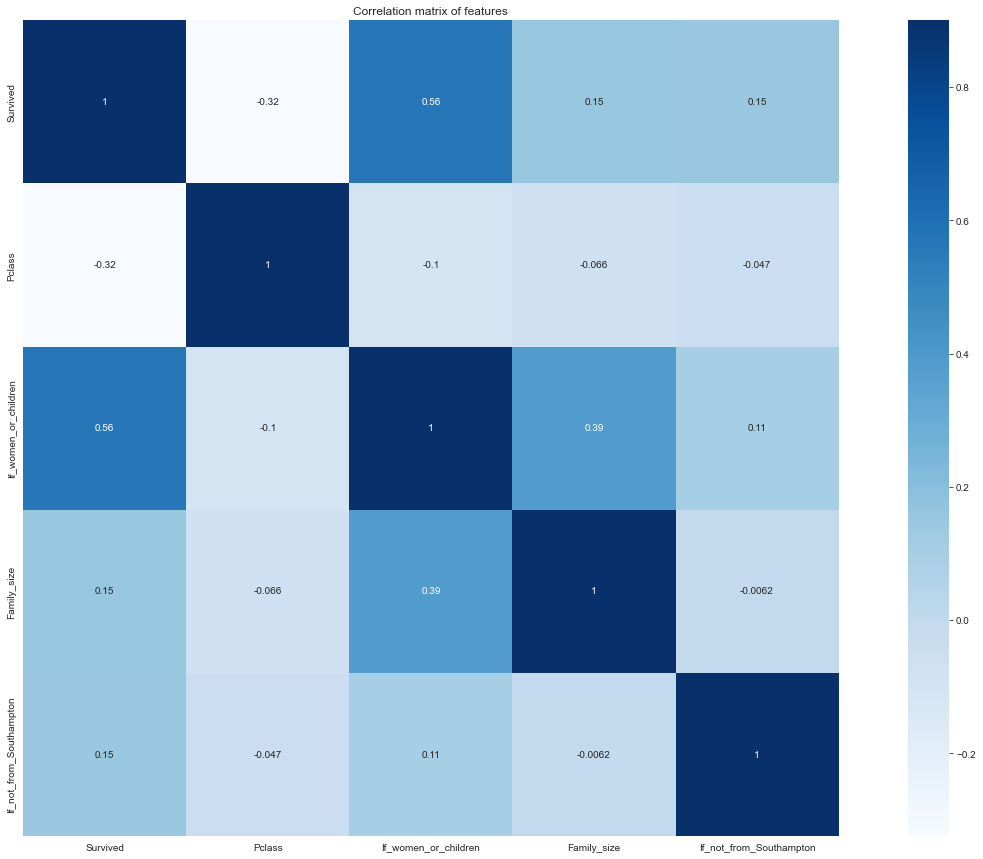

In [22]:
corr = df.corr(method='kendall')
fig, ax = plt.subplots(figsize=(25,15))
sns.heatmap(corr, vmax = 0.9, annot= True,cmap = "Blues",square = True)
plt.title("Correlation matrix of features")
plt.show()
plt.close()

In [23]:
from sklearn.model_selection import train_test_split
y = df['Survived']
df.drop(['Survived'], axis=1, inplace=True)
X = df
#X, x_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=33)
x_pre = df_test

In [24]:
def standardization(x):
    # numerical features
    numeric_features = ['Family_size']
    # copy of datasets
    X_train_stand = x.copy()
    # apply standardization on numerical features
    try:
        for i in numeric_features:
            # fit on training data column
            scale = StandardScaler().fit(X_train_stand[[i]])
            # transform the training data column
            X_train_stand[i] = scale.transform(X_train_stand[[i]])
    except Exception as e:
        pass

    X = X_train_stand
    return X


def normalization(x):
    # data normalization with sklearn
    # fit scaler on training data
    norm = MinMaxScaler().fit(x)
    # transform training data
    X = norm.transform(x)
    return X


def over_sample(x, y):
    # oversample
    ros = SMOTE(random_state=7)
    X, y = ros.fit_resample(x, y)
    return X, y

In [25]:
X,y = over_sample(X,y)

In [26]:
# def print_multiple_scores(model):
#     test_pred = model.predict(x_test)
#     # Accuracy
#     confusion_hard = confusion_matrix(y_test, test_pred)
#     # Determine the individual values of the confusion matrix
#     tn, fp, fn, tp = confusion_hard.ravel()
#
#     # Calculate each individual score
#     model_sens = tp / (tp + fn)
#     model_spec = tn / (tn + fp)
#     model_prec = tp / (tp + fp)
#     model_fpr = fp / (tn + fp)
#     model_npv = tn / (fn + tn)
#
#     # Print all the scores for the user to see
#     print("Sensitity (PPV): \t", model_sens)
#     print("Specificity (TNR):  ", model_spec)
#     print("Precision: \t\t\t", model_prec)
#     print("False Positive Rate:", model_fpr)
#     print("NPV: \t\t\t\t", model_npv)
#
#     accuracy = accuracy_score(y_test, test_pred)
#     precision = precision_score(y_test, test_pred)
#     recall = recall_score(y_test, test_pred)
#     f1 = f1_score(y_test, test_pred)
#     print('\nAccuracy for test set=: {0:.4f}, \nprecision: {1:.4f}, \nrecall: {2:.4f},\
#         \nF1: {3:.4f}'.format(accuracy, precision, recall, f1))
#
#     # confusion_matrix plot
#     import seaborn as sns
#     class_label = ["No_Diabetes", "Diabetes"]
#     df_cm = pd.DataFrame(confusion_hard, index=class_label, columns=class_label)
#     sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
#     plt.title(f'Confusion matrix', fontsize=15)  # title with fontsize 20
#     plt.savefig(f"cm.png", dpi=300)
#     plt.close()


In [27]:
parameter = {'n_neighbors': [15]}
knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parameter, cv=10, n_jobs=5)
clf.fit(X,y)
print(clf.best_score_)

0.7887489574645539


In [28]:
parameters = {'solver': ['sag'], 'max_iter': [2000],
                  'random_state': [7]}
LG = LogisticRegression()
LG = GridSearchCV(LG, parameters, cv=5, n_jobs=5 )
LG.fit(X,y)
print(LG.best_score_)

0.8097011207970113


In [29]:
from pandas import DataFrame

parameters = {'solver': ['adam'], 'max_iter': [2000],
                  'alpha': [0.0001], 'hidden_layer_sizes': np.arange(50, 100),
                  'random_state': [7]}

MLP = MLPClassifier()
MLP = GridSearchCV(MLP, parameters, cv=10, n_jobs=5,return_train_score=True)
MLP.fit(X,y)
print(MLP.best_score_)
#test_pred = MLP.predict(x_pre)
# output = DataFrame({'PassengerId':output})
# for index, row in output.iterrows():
#         output.at[index, 'Survived'] = str(test_pred[index])
# output.to_csv('Titanic/result.csv', index=False)

0.8142452043369476


In [30]:
from sklearn.ensemble import BaggingClassifier
param_grid = {
        'base_estimator__max_depth': [1, 2, 3, 4, 5],
        'max_samples': [0.05, 0.1, 0.2, 0.5]
    }
from sklearn.tree import DecisionTreeClassifier
BAG = BaggingClassifier(
        base_estimator=DecisionTreeClassifier(),
        n_estimators=1000,
        oob_score=True,
        random_state=7
)
BAG = GridSearchCV(BAG, param_grid, cv=10, n_jobs=5,return_train_score=True)
BAG.fit(X,y)
print(BAG.best_score_)

test_pred = BAG.predict(x_pre)
output = DataFrame({'PassengerId':output})
for index, row in output.iterrows():
        output.at[index, 'Survived'] = str(test_pred[index])
output.to_csv('Titanic/result.csv', index=False)

0.8169641367806506


In [31]:
from sklearn.model_selection import cross_val_score, KFold
import xgboost as xgb
# Use "gpu_hist" for training the model.
xgb = xgb.XGBClassifier(tree_method="gpu_hist",n_estimators = 200,enable_categorical =True)
# Fit the model using predictor X and response y.
xgb.fit(X, y, eval_set=[(X, y), (X, y)],
        eval_metric='logloss',
        verbose=True, feature_weights=[04.,0.7,0.1])
# Save model into JSON format.
#reg.save_model("regressor.json")

[0]	validation_0-logloss:0.57353	validation_1-logloss:0.57353
[1]	validation_0-logloss:0.50790	validation_1-logloss:0.50790
[2]	validation_0-logloss:0.46844	validation_1-logloss:0.46844
[3]	validation_0-logloss:0.44389	validation_1-logloss:0.44389
[4]	validation_0-logloss:0.42827	validation_1-logloss:0.42827
[5]	validation_0-logloss:0.41824	validation_1-logloss:0.41824
[6]	validation_0-logloss:0.41106	validation_1-logloss:0.41106
[7]	validation_0-logloss:0.40619	validation_1-logloss:0.40619
[8]	validation_0-logloss:0.40277	validation_1-logloss:0.40277
[9]	validation_0-logloss:0.40037	validation_1-logloss:0.40037
[10]	validation_0-logloss:0.39857	validation_1-logloss:0.39857
[11]	validation_0-logloss:0.39723	validation_1-logloss:0.39723
[12]	validation_0-logloss:0.39642	validation_1-logloss:0.39642
[13]	validation_0-logloss:0.39583	validation_1-logloss:0.39583
[14]	validation_0-logloss:0.39532	validation_1-logloss:0.39532
[15]	validation_0-logloss:0.39497	validation_1-logloss:0.39497
[1

D:\Github Projects\DM\venv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Github Projects\DM\venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[21]	validation_0-logloss:0.39437	validation_1-logloss:0.39437
[22]	validation_0-logloss:0.39405	validation_1-logloss:0.39405
[23]	validation_0-logloss:0.39394	validation_1-logloss:0.39394
[24]	validation_0-logloss:0.39385	validation_1-logloss:0.39385
[25]	validation_0-logloss:0.39365	validation_1-logloss:0.39365
[26]	validation_0-logloss:0.39356	validation_1-logloss:0.39356
[27]	validation_0-logloss:0.39341	validation_1-logloss:0.39341
[28]	validation_0-logloss:0.39319	validation_1-logloss:0.39319
[29]	validation_0-logloss:0.39313	validation_1-logloss:0.39313
[30]	validation_0-logloss:0.39299	validation_1-logloss:0.39299
[31]	validation_0-logloss:0.39286	validation_1-logloss:0.39286
[32]	validation_0-logloss:0.39278	validation_1-logloss:0.39278
[33]	validation_0-logloss:0.39270	validation_1-logloss:0.39270
[34]	validation_0-logloss:0.39256	validation_1-logloss:0.39256
[35]	validation_0-logloss:0.39248	validation_1-logloss:0.39248
[36]	validation_0-logloss:0.39240	validation_1-logloss:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=True,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)